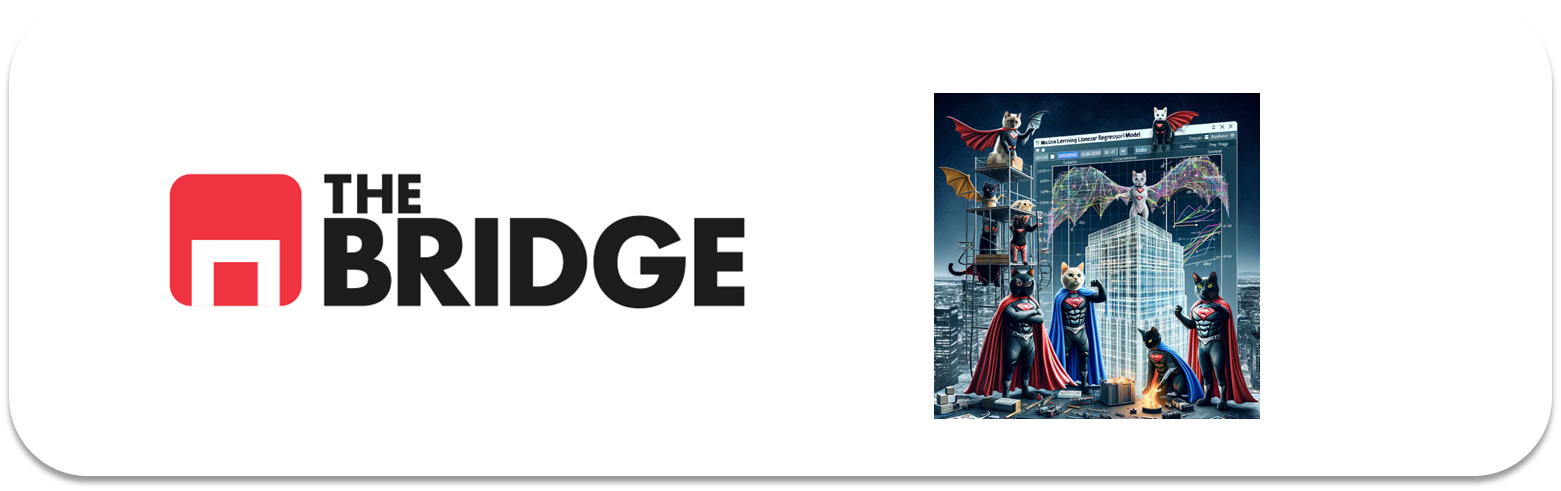

## Clasificación Multicategórica con Regresión Logística

### Entender el problema

Para mostrar la creación de un modelo multiclase y su evaluación vamos a tratar un problema en el que queremos detectar cuál es el sistema operativo de los usuarios que acceden a una dirección web específica (y que no es importante para el problema) en la que pasan un tiempo determinado, navegan a través de las páginas del site, realizan un conjunto de acciones y dejan una valoración de la misma. Encontrarás una variable "clase" que contiene el target, esta vez no tendrás que buscarlo, y que toma tres posibles valores en función del OS: Windows, Linux, Mac. 

Creemos ese modelo predictor a partir de una regresión logística.

### Preparación Datos: Primer vistazo

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [30]:
df_os = pd.read_csv("data/usuarios_win_mac_lin.csv")

clases = {
    0: 'Windows',
    1: 'Linux',
    2: 'Mac'
}

df_os.head(100)

,duracion,paginas,acciones,valor,clase
0,7.0,2,4,8,2
1,21.0,2,6,6,2
2,57.0,2,4,4,2
3,101.0,3,6,12,2
4,109.0,2,6,12,2
...,...,...,...,...,...
95,12.0,1,3,6,2
96,13.0,1,2,16,1
97,11.0,1,2,4,2
98,12.0,1,6,48,1


In [3]:
df_os.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   duracion  170 non-null    float64
 1   paginas   170 non-null    int64  
 2   acciones  170 non-null    int64  
 3   valor     170 non-null    int64  
 4   clase     170 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 6.8 KB


Mostramos el target, y su balanceo o desbalanceo

In [4]:
df_os.clase.value_counts(True)

clase
0    0.505882
2    0.258824
1    0.235294
Name: proportion, dtype: float64

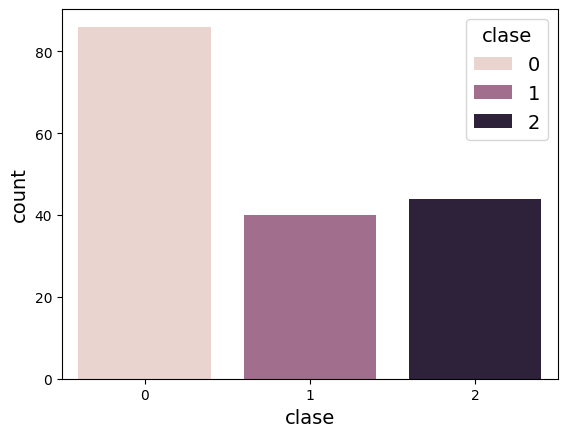

In [5]:
sns.countplot(x = "clase", data = df_os, hue = "clase");

Windows es el sistema dominante y habrá que tenerlo en cuenta a la hora de las medidas y tendríamos que tenerlo en cuenta a la hora de modelar pero lo veremos en sesiones posteriores.

Echamos un vistazo y sólo eso a la distribución de las variables contínuas (o sea casi todas) y nos fijamos en escala y figura

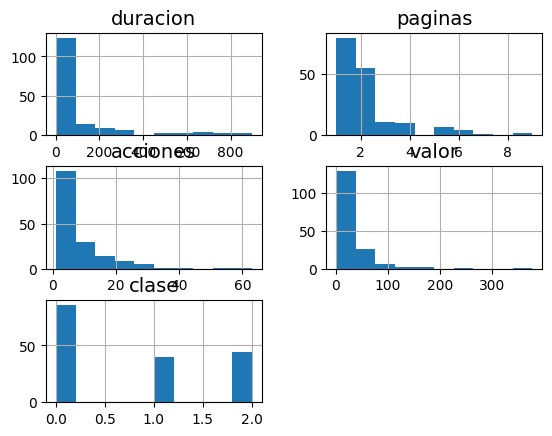

In [6]:
df_os.hist();

Tiene pinta de que vamos a tener que escalar y hacer alguna transformación para "normalizar" las distribuciones.

### Split

Son muy pocos datos (170) pero vamos a hacer el split igual para que vayamos cogiendo el hábito. Además estratificamos sobre el target (pero ojo esto es para hacer más limpio el ejercicio, por ejemplo porque suponemos que es algo que se va a mantener debido al marketshare de cada sistema operativo)

In [7]:
# Hacemos el split (división) del dataset en train y test
# df_os → es el dataset que vamos a dividir

train_set, test_set = train_test_split(
    df_os,            # El dataset completo
    test_size=0.2,    # 20% de los datos será para test
    stratify=df_os["clase"],  # Mantiene la misma proporción de clases en train y test
    random_state=42   # Semilla para que la división siempre sea igual (reproducible)
)


In [8]:
train_set["clase"].value_counts(normalize = True)

clase
0    0.507353
2    0.257353
1    0.235294
Name: proportion, dtype: float64

🎯 Resumen  
train_test_split divide el dataset en entrenamiento y prueba.  
test_size=0.2 → 20% para test.  
stratify=df_os["clase"] → asegura que las clases estén balanceadas en ambos conjuntos.   
random_state=42 → hace la división reproducible.  

In [9]:
test_set["clase"].value_counts(normalize = True)

clase
0    0.500000
2    0.264706
1    0.235294
Name: proportion, dtype: float64

No es perfecto, pero prueba a hacer el split sin estratificar.

### Mini-EDA

Vamos a ver la correlación de las variables con el target, pero realmente son tan pocas que no vamos a quitar ninguna:

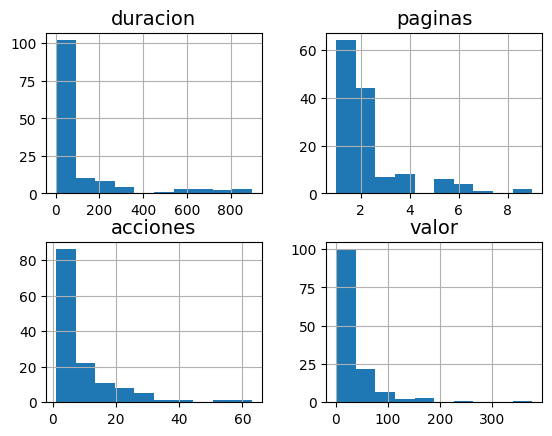

In [10]:
train_set.drop("clase", axis = 1).hist()
plt.show()

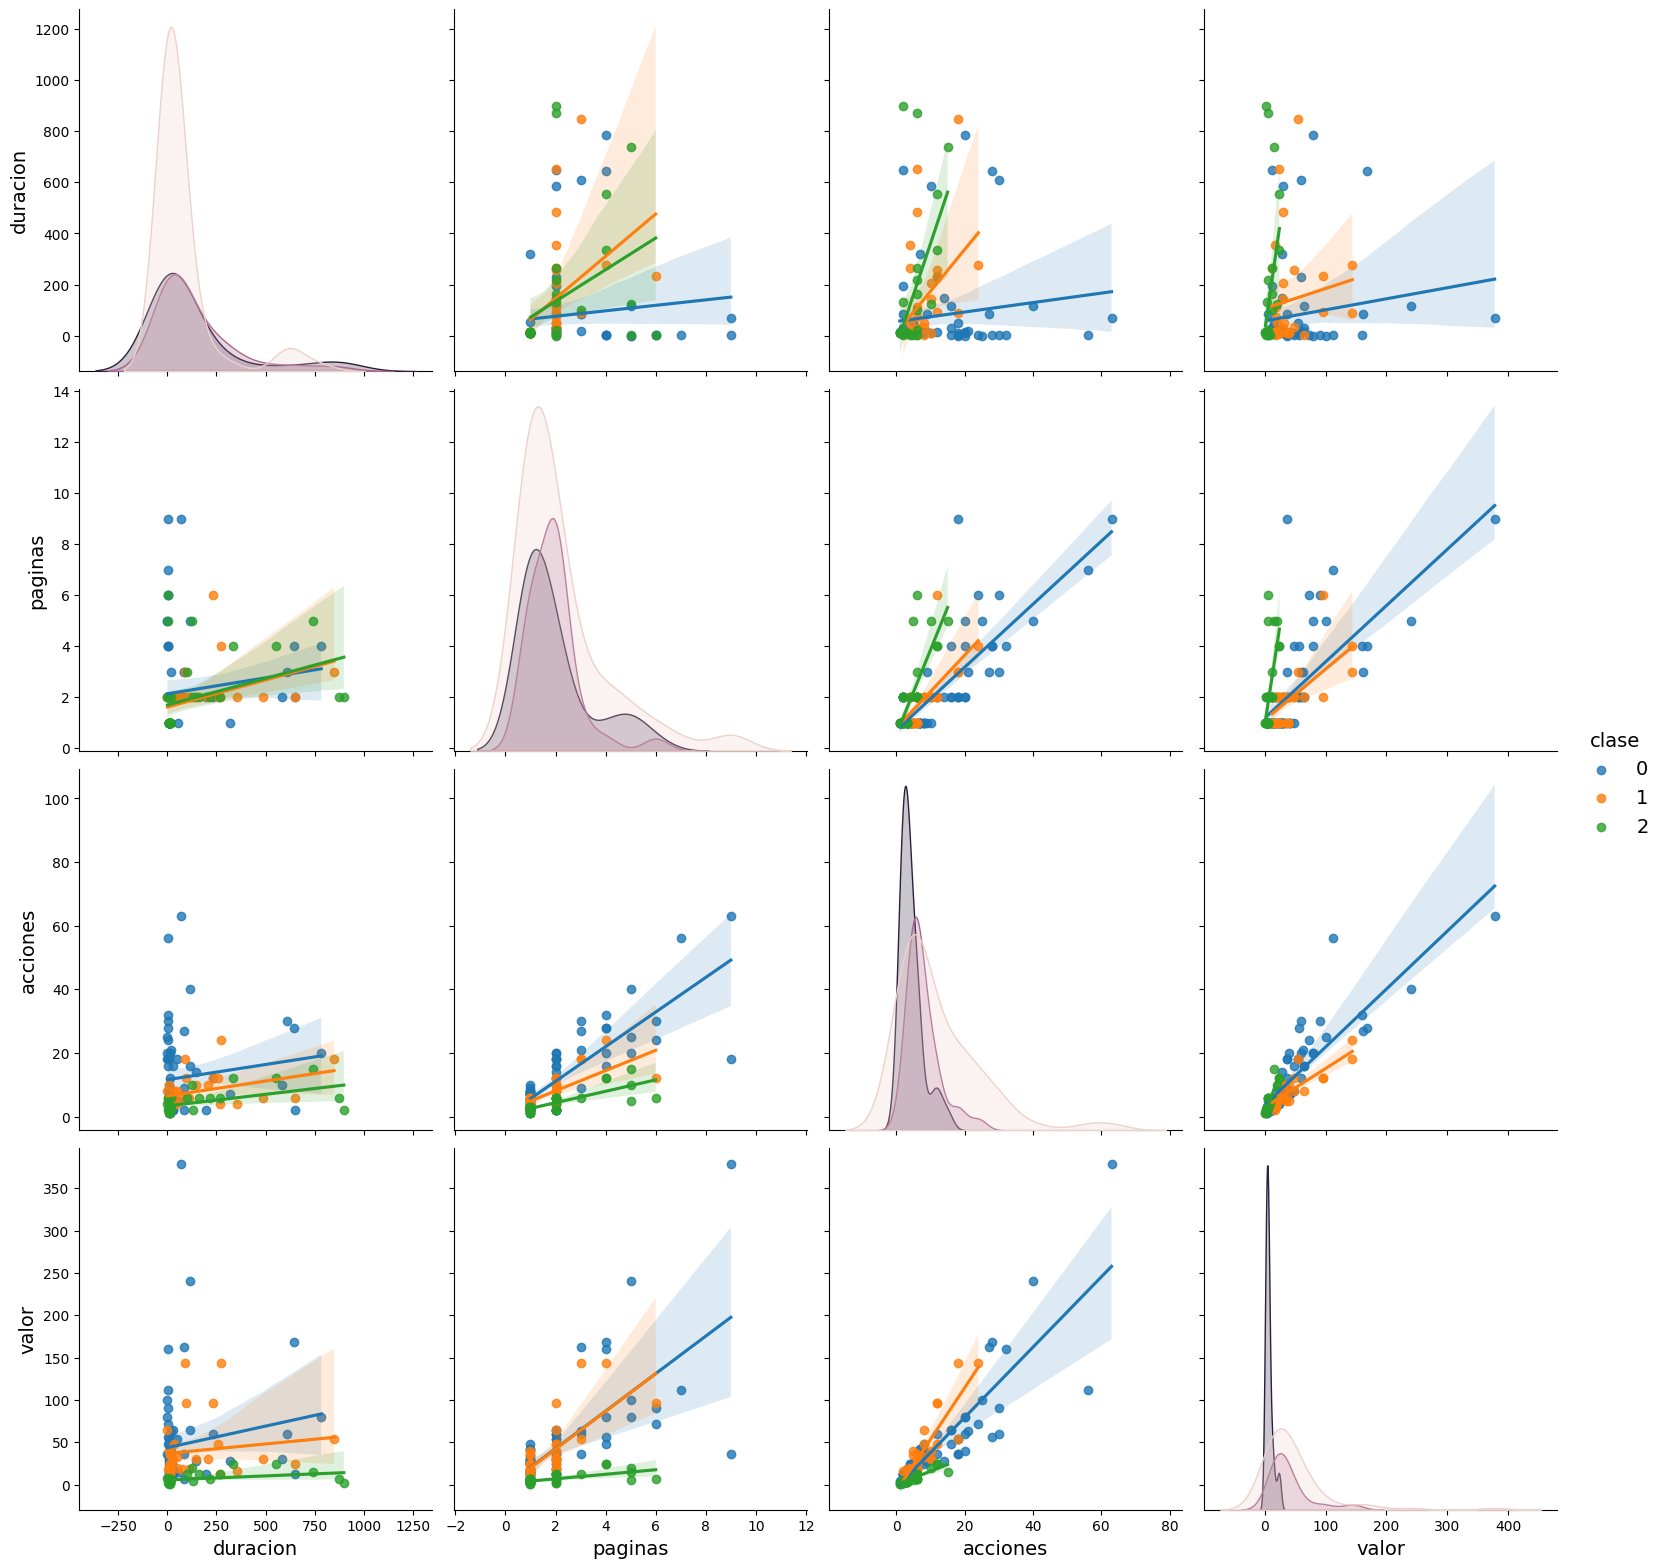

In [11]:
sns.pairplot(train_set,
            hue='clase',
            height=4,
            vars=["duracion", "paginas","acciones","valor"],
            kind='reg'); # "reg" de regresión lineal

In [12]:
features = train_set.drop("clase", axis = 1).columns.to_list()
print(features)

['duracion', 'paginas', 'acciones', 'valor']


### Procesamiento de Features

array([[<Axes: title={'center': 'duracion'}>,
        <Axes: title={'center': 'paginas'}>],
       [<Axes: title={'center': 'acciones'}>,
        <Axes: title={'center': 'valor'}>]], dtype=object)

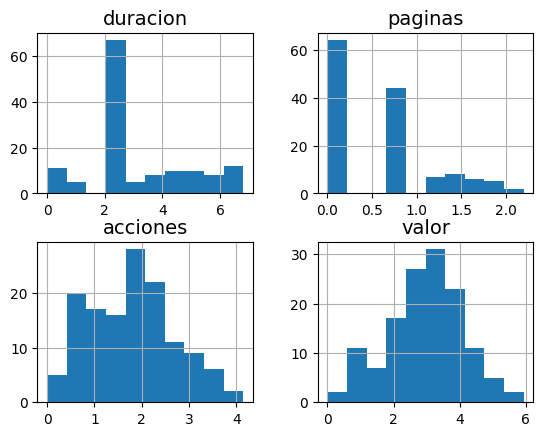

In [13]:
# Recorremos cada columna numérica que queremos transformar
for col in features:
    
    # Aplicamos la transformación logarítmica a la columna
    # np.log reduce la escala de valores muy grandes y hace las distribuciones más "normales"
    train_set[col] = train_set[col].apply(np.log)

# Dibujamos los histogramas de todas las columnas transformadas
train_set[features].hist()


“Aplicamos logaritmos a las columnas numéricas para reducir la escala, suavizar valores extremos y mejorar la normalidad de las distribuciones. Esto suele ayudar a los modelos a entrenar mejor

In [14]:
for col in features:
    test_set[col] = test_set[col].apply(np.log)
# Ojo ni lo mires :-), pero tienes que aplicarle las mismas transformaciones que el train.

In [15]:
from sklearn.preprocessing import StandardScaler

# Creamos el objeto StandardScaler
scaler = StandardScaler()

# Ajustamos ("fit") el scaler SOLO con los datos de entrenamiento
# Esto calcula la media y la desviación estándar del TRAIN
scaler.fit(train_set[features])

# Transformamos el TRAIN usando esa media y desviación
# El resultado lo convertimos a DataFrame para mantener nombres de columnas
X_train = pd.DataFrame(
    scaler.transform(train_set[features]),   # Aplica la estandarización
    columns=features                         # Mantiene nombres originales
)

# Transformamos el TEST usando la MISMA media y desviación del TRAIN
# (Esto es muy importante para evitar fuga de información)
X_test = pd.DataFrame(
    scaler.transform(test_set[features]),
    columns=features
)

# Miramos cómo quedan las distribuciones estandarizadas del TRAIN
X_train.describe()


,duracion,paginas,acciones,valor
count,1.360000e+02,1.360000e+02,1.360000e+02,1.360000e+02
mean,-1.632681e-16,-4.571507e-17,2.416368e-16,-3.395976e-16
std,1.003697e+00,1.003697e+00,1.003697e+00,1.003697e+00
min,-1.878357e+00,-8.947527e-01,-2.004312e+00,-2.501146e+00
25%,-4.781410e-01,-8.947527e-01,-7.831545e-01,-7.258228e-01
50%,-3.805922e-01,2.695613e-01,-1.268982e-02,2.121177e-01
75%,7.491348e-01,2.695613e-01,7.577748e-01,6.482352e-01
max,2.092503e+00,2.796035e+00,2.600971e+00,2.565771e+00


“Estandarizamos las features para que tengan media 0 y desviación 1.
Ajustamos (fit) el StandardScaler solo con el TRAIN para evitar fuga de información.
Luego aplicamos la transformación (transform) tanto a TRAIN como TEST usando los valores aprendidos en el TRAIN.” 

👉 El test debe estar en la misma escala que el train,  
👉 pero sin que influyan sus propios valores.  
Ejemplo simple:  
Si en train la media de “edad” es 50  
y en test hay edades 18–70…  
Usamos media=50, desviación del train.  
Así el modelo interpreta todo en la misma escala.  



In [16]:
y_train = train_set["clase"]
y_test = test_set["clase"]

### Creamos el modelo

In [17]:
from sklearn.linear_model import LogisticRegression

# Creamos el modelo de Regresión Logística
# max_iter=10000 → aumenta el número de iteraciones para que el algoritmo pueda converger
clf = LogisticRegression(max_iter=10000)

# Entrenamos el modelo con los datos ya estandarizados
# X_train = variables predictoras
# y_train = variable objetivo (clase)
clf.fit(X_train, y_train)

# Nota: no hace falta especificar nada más.
# LogisticRegression detecta automáticamente si es binario o multiclase
# y usa la estrategia adecuada (one-vs-rest).


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

“Creamos un modelo de regresión logística con más iteraciones para asegurar la convergencia. Entrenamos usando X_train y y_train. El modelo detecta automáticamente si el problema es binario o multiclase.”

Si mostramos los coeficientes o pesos del modelo veremos que en realidad ha entrenado un modelo de regresión logística para cada clase como vimos en la sesión de teoría. Ha hecho un one-vs-rest

In [18]:
clf.coef_

array([[-0.33863361, -0.28274505, -0.12062857,  1.06620115],
       [ 0.20874616, -0.29908782, -0.96460776,  1.88037632],
       [ 0.12988745,  0.58183287,  1.08523633, -2.94657748]])

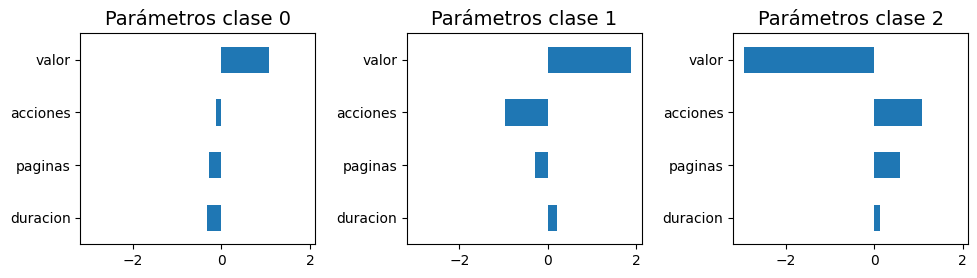

In [19]:
# Convertimos los coeficientes del modelo en un DataFrame
# clf.coef_ → matriz con los coeficientes learned por la regresión logística
# X_train.columns → nombres de las variables (features)
df_coefs = pd.DataFrame(clf.coef_, columns=X_train.columns)

# Creamos una figura con 1 fila y 3 columnas (1x3 subplots)
# figsize controla el tamaño de la figura
# sharex=True → todas las gráficas comparten escala horizontal
fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharex=True)

# Recorremos cada fila de los coeficientes (una por clase)
for i, subdf in df_coefs.iterrows():

    # Dibujamos un gráfico de barras horizontal (barh)
    # ax[i] → elegimos el subplot correspondiente
    subdf.plot(kind="barh", ax=ax[i])

    # Ponemos un título indicando la clase a la que pertenecen esos coeficientes
    ax[i].set_title(f"Parámetros clase {i}")

# Ajustamos los espacios entre gráficos para que no se solapen
fig.tight_layout()


“Convertimos los coeficientes del modelo en un DataFrame para poder graficarlos. Creamos subplots y dibujamos gráficos de barras horizontales que muestran la importancia y el signo de cada coeficiente para cada clase.”

Ten en cuenta que estos coeficientes están aplicados sobre el logaritmo de las variables, aún así puedes ver que influye en la selección de cada clase.

Podemos ver las predicciones

In [20]:
clf.predict(X_train)

array([0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       2, 2, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 1,
       0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1,
       0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 2, 0, 2, 2, 0, 2,
       2, 0, 2, 0])

Y las probabilidades para cada instancia, nos da un vector de tres probabilidades una para cada clase y puedes comprobar que escoge la de mayor probabilidad:

In [21]:
clf.predict_proba(X_train)

array([[0.71644988, 0.2743894 , 0.00916072],
       [0.39525661, 0.10499886, 0.49974453],
       [0.62553767, 0.33527652, 0.03918582],
       [0.67466005, 0.32187826, 0.00346169],
       [0.19053689, 0.13965596, 0.66980715],
       [0.38941522, 0.10636455, 0.50422023],
       [0.53907471, 0.45969679, 0.00122851],
       [0.75884966, 0.2158255 , 0.02532484],
       [0.46966258, 0.05475959, 0.47557783],
       [0.59096562, 0.24208018, 0.16695421],
       [0.68823716, 0.30915273, 0.00261011],
       [0.70714319, 0.28772779, 0.00512902],
       [0.74887583, 0.21917341, 0.03195076],
       [0.71324451, 0.26650969, 0.02024579],
       [0.80850583, 0.17530331, 0.01619086],
       [0.70440058, 0.21908523, 0.07651419],
       [0.60969579, 0.38175854, 0.00854567],
       [0.57631578, 0.38246988, 0.04121434],
       [0.8860096 , 0.06851385, 0.04547655],
       [0.59458687, 0.3295515 , 0.07586163],
       [0.48135544, 0.49433957, 0.02430499],
       [0.33808028, 0.52313293, 0.13878679],
       [0.

In [22]:
from sklearn.metrics import accuracy_score

# Calculamos la accuracy en el conjunto de entrenamiento
# clf.predict(X_train) → predicciones del modelo sobre los datos de TRAIN
# y_train → las etiquetas reales de TRAIN
acc_train = accuracy_score(y_train, clf.predict(X_train))

# Imprimimos el resultado
print(acc_train)


0.7279411764705882


En este caso vemos que el accuracy es superior a la contribución de la clase mayoritaria, no tiene mala pinta (pero recuerda que es el train). No vamos a ver el test, antes vamos a usar la validación cruzada y luego veremos las métricas para multiclase.

***

### Validamos el modelo

Usemos la validación cruzada no tanto para comparar con otros modelos, que no tenemos, sino como para adelantarnos a la evaluación con el test y de nuevo ir cogiendo hábito.

In [23]:
from sklearn import model_selection

# Nombre del modelo (solo para mostrar por pantalla)
name = 'Logistic Regression'

# Hacemos validación cruzada (cross-validation) con 5 particiones (cv=5)
# cross_val_score divide el TRAIN en 5 partes, entrena y evalúa 5 veces,
# y devuelve la accuracy obtenida en cada una.
cv_results = model_selection.cross_val_score(
    clf,          # modelo entrenado
    X_train,      # datos de entrenamiento (features)
    y_train,      # etiquetas verdaderas
    cv=5,         # número de particiones (5 folds)
    scoring='accuracy'   # métrica que queremos calcular
)

# Creamos un mensaje mostrando la media y la desviación estándar
msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())

# Imprimimos los 5 resultados individuales de las 5 particiones
print(cv_results)

# Imprimimos la media y la desviación estándar
print(msg)


[0.64285714 0.62962963 0.66666667 0.66666667 0.77777778]
Logistic Regression: 0.676720 (0.052496)


✔ Hace Validación Cruzada (Cross-Validation)  
Es una técnica para evaluar un modelo de forma más fiable que usando solo un train/test.  
Funciona así:  
El TRAIN se divide en 5 partes (folds).  
En cada iteración:  
el modelo entrena con 4 partes  
evalúa con la parte restante  
Al final tienes 5 accuracies, una por cada fold.  

✔ Media = 0.676  
El modelo acierta un 67.6% en promedio.  
✔ Desviación estándar = 0.052  
El rendimiento varía un poco entre folds, pero no demasiado.  

“Hacemos validación cruzada para evaluar el modelo de forma más robusta. Cross_val_score divide el train en 5 partes, entrena y evalúa 5 veces, y devuelve la accuracy de cada iteración. La media y desviación estándar muestran qué tal generaliza el modelo.

Ya vemos que sale menor que el 72% del train. 

### Evaluación del modelo

In [24]:
# Importamos diversas métricas que usaremos para evaluar el modelo
from sklearn.metrics import (
    precision_score,        # mide precisión
    recall_score,           # mide sensibilidad/recall
    accuracy_score,         # mide exactitud global
    balanced_accuracy_score,# accuracy balanceada (útil si hay clases desbalanceadas)
    roc_auc_score,          # área bajo la curva ROC
    roc_curve,              # puntos de la curva ROC
    precision_recall_curve, # curva precisión-recall
    confusion_matrix,       # matriz de confusión
    ConfusionMatrixDisplay  # herramienta para graficar matriz de confusión
)

In [25]:
# Obtenemos las probabilidades de pertenecer a cada clase
# predict_proba devuelve una matriz con dos columnas: prob clase 0, prob clase 1
y_proba = clf.predict_proba(X_test)

# Obtenemos las predicciones finales (0 o 1)
# predict usa un umbral de 0.5 por defecto
y_pred = clf.predict(X_test)

#### Matriz de confusion

A mano, como un dataframe a partir de los datos que nos da el `confusion_matrix` de sklearn:

In [26]:
# Creamos un DataFrame con la matriz de confusión generada por sklearn
cm = pd.DataFrame(
    confusion_matrix(y_test, y_pred),              # matriz de confusión (valores numéricos)
    index=[f"Real {i}" for i in clf.classes_],     # nombres de filas → clases reales
    columns=[f"Predicho {i}" for i in clf.classes_] # nombres de columnas → clases predichas
)

# Mostramos el DataFrame
cm


,Predicho 0,Predicho 1,Predicho 2
Real 0,14,0,3
Real 1,3,5,0
Real 2,0,0,9


“Generamos la matriz de confusión con sklearn y la convertimos en un DataFrame para verla más clara, utilizando nombres dinámicos para las filas (reales) y columnas (predichas). La matriz muestra los aciertos y errores del modelo por clase.”

Gráficamente:

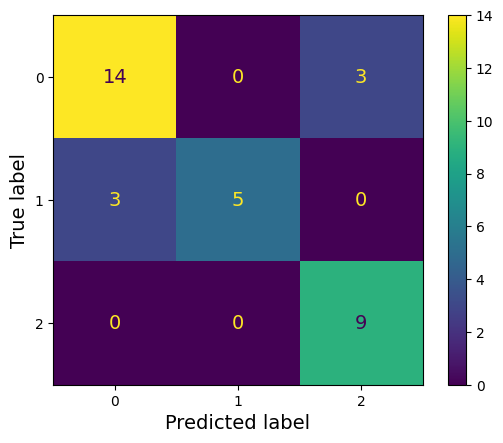

In [27]:
# Mostramos la matriz de confusión de una forma rápida y visual
# y_test = valores reales
# y_pred = predicciones del modelo
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


“ConfusionMatrixDisplay.from_predictions calcula y dibuja automáticamente la matriz de confusión usando valores reales y predicciones. Es la forma más rápida de visualizar los aciertos y errores del modelo.”

In [28]:
# Dibujamos un heatmap (mapa de calor) de la matriz de confusión normalizada
sns.heattmap(
    cm / np.sum(cm),   # Normalizamos dividiendo cada celda entre el total
    annot=True,        # Mostramos los valores dentro de cada celda
    fmt='.2%',         # Formato: porcentaje con 2 decimales
    cmap='Blues'       # Paleta de colores azul
);


AttributeError: module 'seaborn' has no attribute 'heattmap'

Normalizamos la matriz de confusión dividiendo cada celda entre el total para obtener porcentajes. Con heatmap dibujamos un gráfico con colores y anotaciones para interpretar más fácilmente los aciertos y errores del modelo.”

### Métricas MACRO y MICRO

In [ ]:
# PRECISIÓN (qué porcentaje de predicciones positivas fueron correctas)
micro_prec = precision_score(y_test, y_pred, average="micro")
print("MICRO PRECISION:", micro_prec)

macro_prec = precision_score(y_test, y_pred, average="macro")
print("MACRO PRECISION:", macro_prec)


# RECALL (qué porcentaje de positivos reales detectó el modelo)
micro_rec = recall_score(y_test, y_pred, average="micro")
print("MICRO RECALL:", micro_rec)

macro_rec = recall_score(y_test, y_pred, average="macro")
print("MACRO RECALL:", macro_rec)


# ACCURACY (porcentaje total de aciertos)
micro_acc = accuracy_score(y_test, y_pred)
print("MICRO ACCURACY:", micro_acc)


MICRO PRECISION: 0.8235294117647058
MACRO PRECISION: 0.8578431372549019
MICRO RECALL: 0.8235294117647058
MACRO RECALL: 0.8161764705882352
MICRO ACCURACY: 0.8235294117647058


Este bloque calcula métricas de micro y macro para problemas multiclase.  
Cuando hay 3 o más clases, como en tu caso, debemos elegir cómo combinar los resultados.  
“Micro: combina todas las clases para calcular precision, recall y accuracy → mide el rendimiento global.  
Macro: calcula la métrica por clase y luego hace la media → muestra si el modelo trata bien a todas las clases por igual.”  

In [ ]:
# Calculamos la accuracy del modelo en el conjunto de test
acierto = accuracy_score(y_test, y_pred)

# El error es simplemente el complemento de la accuracy
error = 1 - acierto

# Mostramos los resultados en porcentaje con dos decimales
print("Acierto:", round(acierto*100, 2), "%")
print("Error:", round(error*100, 2), "%")


Acierto: 82.35 %
Error: 17.65 %


✔ El modelo predice correctamente el 82.35% de los casos  
👉 8.2 de cada 10 predicciones son correctas  
✔ El modelo se equivoca en el 17.65%  
👉 1.7 de cada 10 predicciones son incorrectas  

“Calculamos el porcentaje de aciertos del modelo usando accuracy. El error es 1 menos la accuracy. Mostramos ambos en porcentaje para interpretarlos fácilmente.”


#### Informe de Resultados

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        17
           1       1.00      0.62      0.77         8
           2       0.75      1.00      0.86         9

    accuracy                           0.82        34
   macro avg       0.86      0.82      0.82        34
weighted avg       0.85      0.82      0.82        34



#### Clasificación de nuevos registros

Para terminar veamos como sería la predicción para un usuario que dedica una duración de 1, ve 1 página, ejecuta 1 acción y valora con 2 el site

In [ ]:
new_data = pd.DataFrame(scaler.transform(np.log(np.array([[1, 1, 1, 2]]))),columns = features)
print(new_data)
print(clf.predict_proba(new_data))
print(clf.predict(new_data))

   duracion   paginas  acciones     valor
0 -1.878357 -0.894753 -2.004312 -1.909372
[[0.13075762 0.02107934 0.84816304]]
[2]


c:\Users\diana\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
